In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="colorblind")
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_hdf("data/sci.h5", 'table')

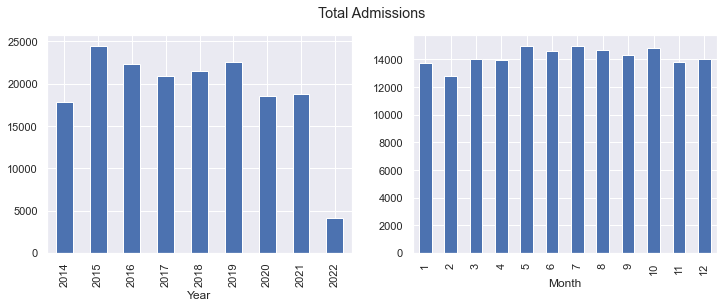

In [3]:
def total_admissions(df: pd.DataFrame, years=(2014, 2022), col='AdmissionDateTime'):
    dfc = df[df[col].dt.year.between(*years)][col]
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle('Total Admissions')
    df[col].groupby(dfc.dt.year).count().plot.bar(ax=ax[0], xlabel='Year')
    df[col].groupby(dfc.dt.month).count().plot.bar(ax=ax[1], xlabel='Month')

total_admissions(df)

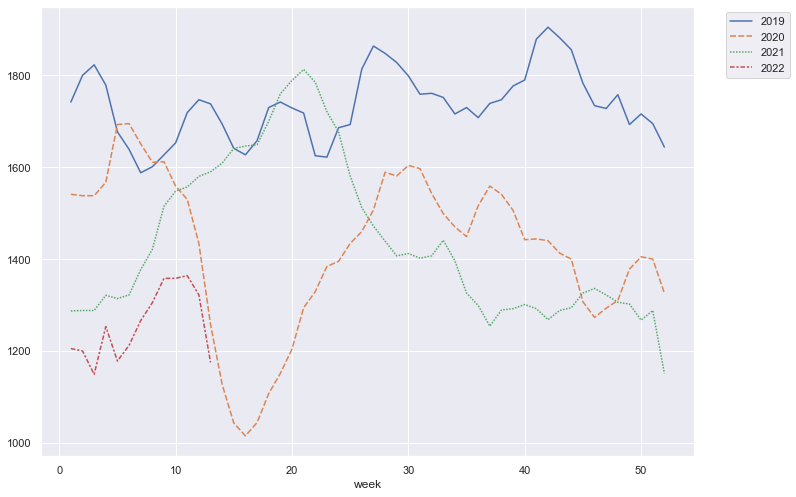

In [4]:
def monthly_admissions_per_year(df: pd.DataFrame, years=range(2019, 2023), col='AdmissionDateTime'):
    grouped = df[col].groupby(
        [df[col].dt.year, df[col].dt.isocalendar().week]
    ).count().drop(53, level=1)

    # Manual corrections due to week weirdness
    grouped.loc[2014, 52] += grouped.loc[2014, 1]
    grouped.loc[2022, 1] += grouped.loc[2022, 52]
    grouped.loc[2014, 1], grouped.loc[2022, 52] = np.nan, np.nan

    grouped = grouped.rolling(4).sum().unstack(level=0)

    sns.lineplot(
        data=grouped[years]
    )
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

monthly_admissions_per_year(df)

<AxesSubplot:xlabel='AdmissionDateTime'>

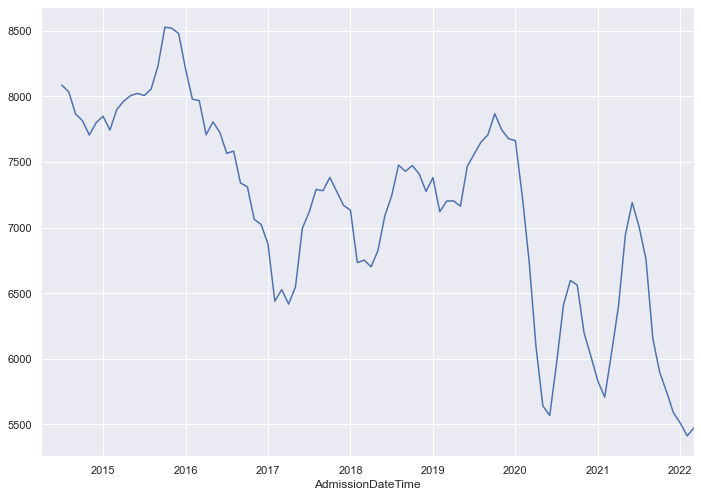

In [5]:
def quarterly_admissions_rolling(df: pd.DataFrame, col='AdmissionDateTime') -> pd.Series:
    return df[col].groupby(
        df[col].dt.to_period("M")
    ).count().rolling(4).sum()

quarterly_admissions_rolling(df).plot()

In [6]:
def period_count(df, period="M", col='AdmissionDateTime'):
    return df[col].groupby(
        df[col].dt.to_period(period)
    ).count()

<AxesSubplot:xlabel='AdmissionDateTime'>

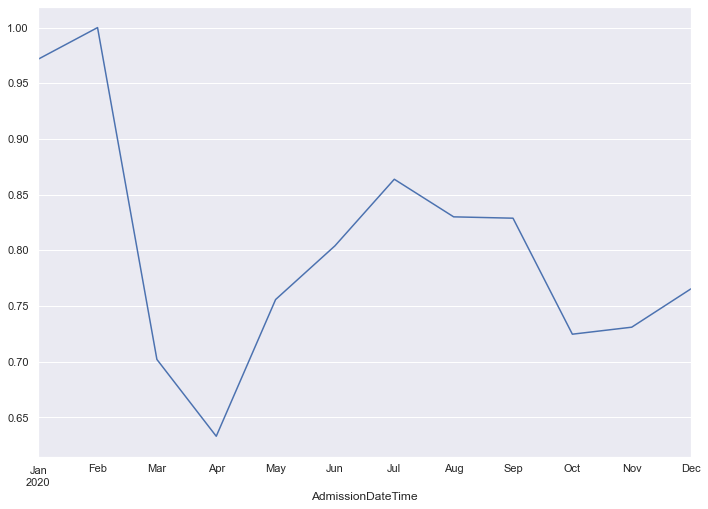

In [7]:
def compare_years(df, x = 2019, y=2020, baseline=2):
    x, y = min(x,y), max(x,y)
    months = period_count(df[df.AdmissionDateTime.dt.year.between(x,y)])
    base_x, base_y = \
        months.loc[pd.Period(freq="M", year=x, month=baseline)], months.loc[pd.Period(freq="M", year=y, month=baseline)]
    r = (months/months.shift(12))*(base_x/base_y)
    return r.dropna()
compare_years(df).plot()

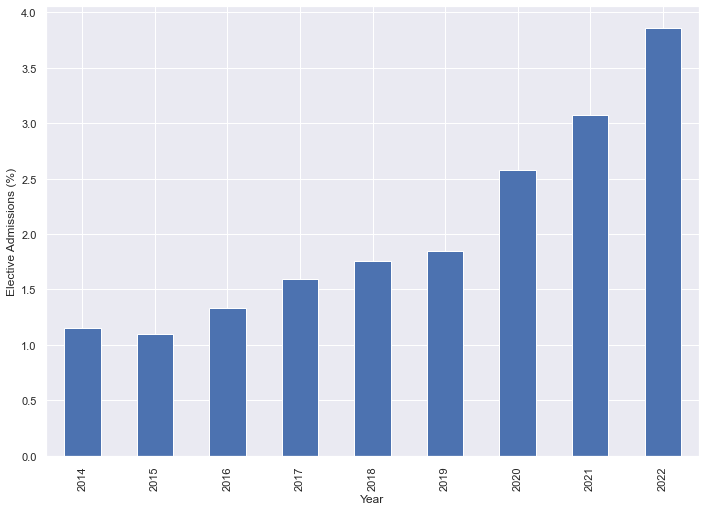

In [8]:
def elective_admissions_prop_yearly(df):
    grouped = df.groupby(
            [df.AdmissionDateTime.dt.year, df.ElectiveAdmission]
        ).SpellSerial.count()
    el, nonel = grouped.xs(True, level=1), grouped.xs(False, level=1)
    (el*100/(el+nonel)).plot.bar(xlabel='Year', ylabel='Elective Admissions (%)')
    
elective_admissions_prop_yearly(df)

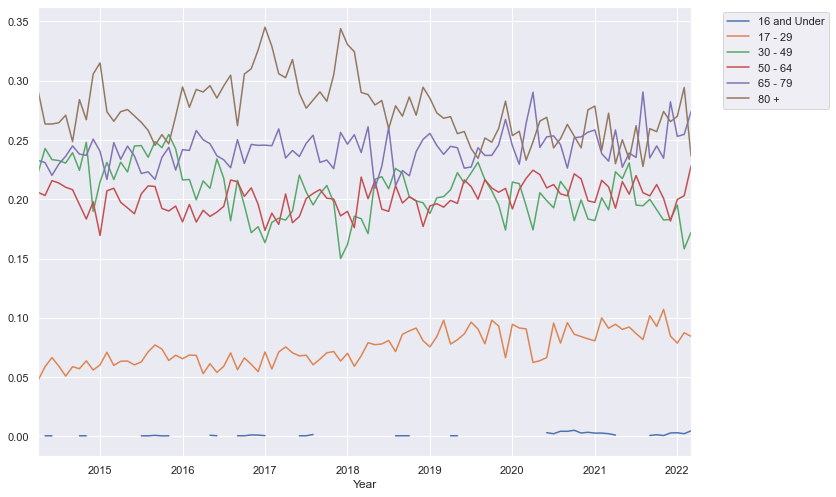

In [9]:
def band_proportions_yearly(df, col='AgeBand'):
    g = df.groupby(
        [df.AdmissionDateTime.dt.year, col]
    )[col].count()
    (g/g.sum(level=0)).unstack(level=1).plot(xlabel='Year')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

def band_proportions_monthly(df, col='AgeBand'):
    g = df.groupby(
        [df.AdmissionDateTime.dt.to_period("M"), col]
    )[col].count()
    (g/g.sum(level=0)).unstack(level=1).plot(xlabel='Year')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
band_proportions_monthly(df)

<AxesSubplot:xlabel='AdmissionDateTime'>

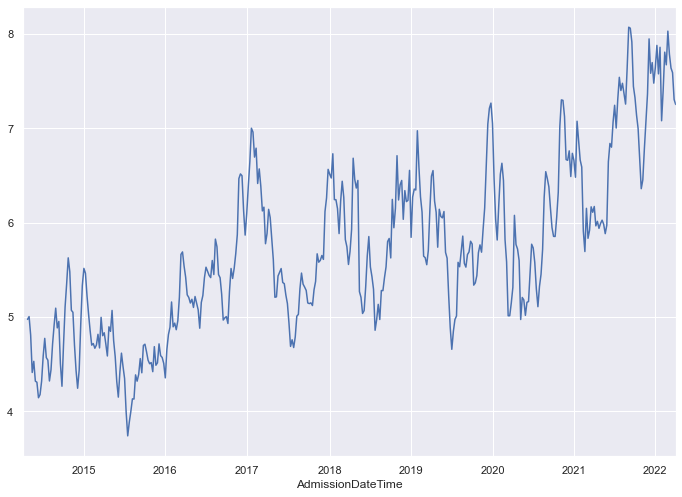

In [10]:
df.groupby(
        df.AdmissionDateTime.dt.to_period("W")
).TotalLOS.mean().rolling(4).mean().plot()

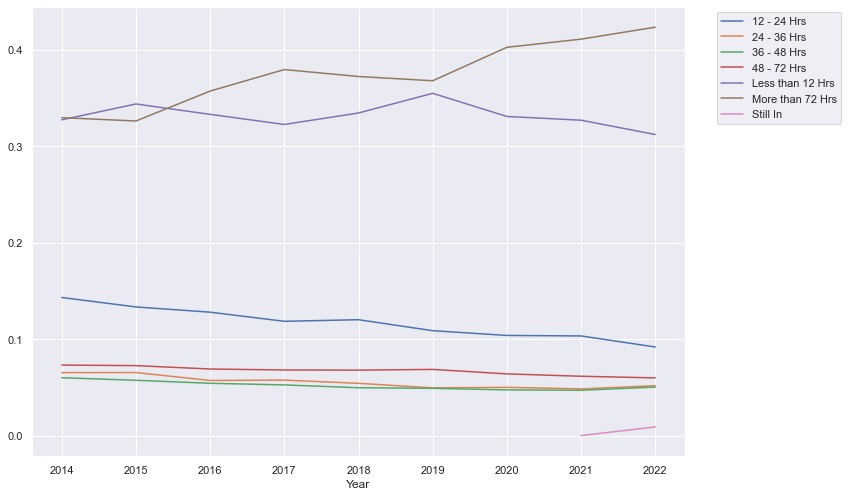

In [11]:
band_proportions_yearly(df, 'LOSBand')

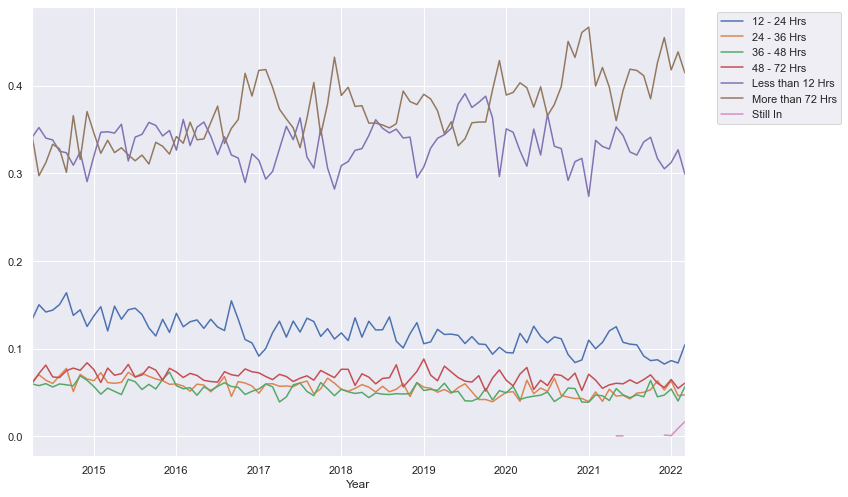

In [12]:
band_proportions_monthly(df, 'LOSBand')

In [13]:
df['ICDLetter'] = df.MainICD10.str[0]
df['ICDNum'] = df.MainICD10.str[1:3]
df['ICDLetNum'] = df.MainICD10.str[:3]

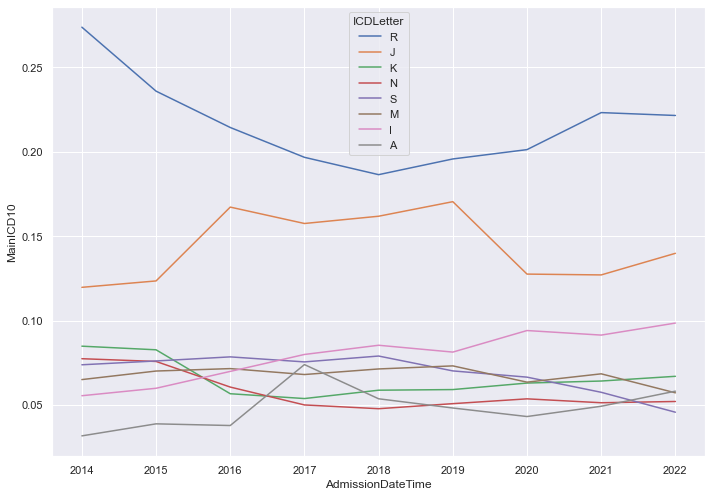

In [14]:
def ICD_letters_yearly(df):
    g = df.groupby([df.AdmissionDateTime.dt.year, df.ICDLetter]).MainICD10.count()
    g = (g/g.sum(level=0)).reset_index()
    u = g.groupby('AdmissionDateTime').apply(lambda x: x.nlargest(5, 'MainICD10')).ICDLetter.unique()
    sns.lineplot(data=(g.set_index('ICDLetter').loc[u]).reset_index(), y='MainICD10', x='AdmissionDateTime', hue='ICDLetter')

ICD_letters_yearly(df)

In [15]:
g = df.groupby([df.AdmissionDateTime.dt.year, df.ICDLetter, df.ICDNum]).SpellSerial.count()
yearly_prop = g/g.sum(level=0)
letter_prop = g/g.sum(level=[0,1])
yearly_prop.loc[2022]

ICDLetter  ICDNum
A          02        0.000244
           04        0.003666
           08        0.005132
           09        0.011241
           19        0.000244
                       ...   
Z          03        0.000489
           04        0.000489
           09        0.000244
           73        0.000244
n          an        0.014418
Name: SpellSerial, Length: 390, dtype: float64

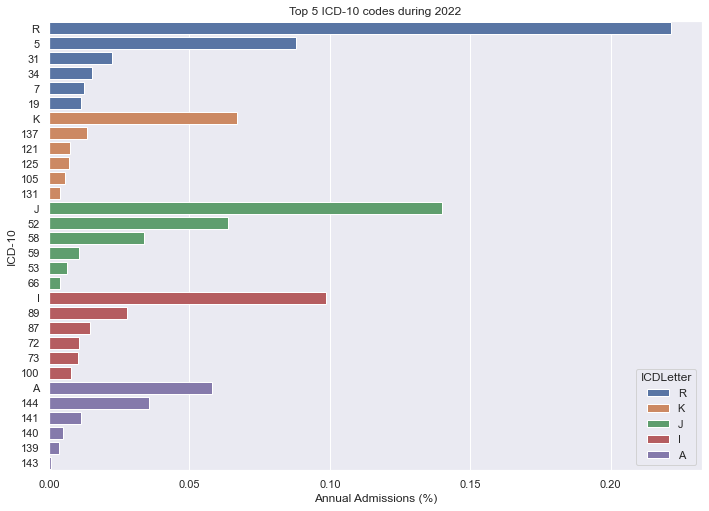

In [18]:
def topn_icd_in_year(df, year=2022, n=5):
    # Get proportions per opcode during the chosen year
    g = df.groupby(
        [df.AdmissionDateTime.dt.year, df.ICDLetter, df.ICDNum]
    ).SpellSerial.count()
    g = (g / g.sum(level=0)).loc[year]

    # Get the top letters for the year
    top_letters = g.sum(level=0).nlargest(n).to_frame().reset_index()
    top_letters["level_1"] = top_letters.ICDLetter

    g = (
        g.loc[top_letters.ICDLetter]
        .reset_index()
        .groupby("ICDLetter")
        .SpellSerial.nlargest(5)
        .reset_index()
    )
    g = pd.concat([top_letters, g])

    ax = sns.barplot(
        data=g.sort_values(["ICDLetter", "SpellSerial"]*100, ascending=False),
        x="SpellSerial",
        y="level_1",
        hue="ICDLetter",
        dodge=False,
    )
    ax.set(xlabel='Annual Admissions (%)', ylabel='ICD-10', title=f'Top {n} ICD-10 codes during {year}')

topn_icd_in_year(df)

In [17]:
y = g.loc[2021].nlargest(15).reset_index()
sns.barplot(data=y, x='SpellSerial', y='ICDLetNum')

ValueError: Could not interpret input 'ICDLetNum'